In [79]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   
#그래프에서 마이너스 기호가 표시되도록 하는 설정입니다.

%matplotlib notebook

## 기본 패키지 임폴트 및 데이터 불러오기(손대지 않아도 됨)

In [80]:
import pandas as pd
import numpy as np

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [82]:
train = pd.read_csv("train.csv",encoding="ansi", parse_dates=['시간'])
test = pd.read_csv("test.csv",encoding="ansi", parse_dates=['시간'])

In [83]:
train.head()

,고백성공여부,이름,시간,나이(본인),나이(상대방),외모점수,알고 지낸 기간,관심사(본인),관심사(상대방),식사
0,1,강영연,2018-07-21 06:10:00,23,27,47,2,스포츠,게임,일식
1,1,유지용,2018-12-19 03:26:00,22,26,10,1,게임,스포츠,양식
2,1,하희동,2019-12-08 00:58:00,27,28,96,5,게임,영화,한식
3,0,권우수,2019-05-10 00:46:00,27,29,70,2,음악,스포츠,일식
4,0,김현동,2018-12-10 03:48:00,22,22,22,1,게임,음악,중식


<IPython.core.display.Javascript object>


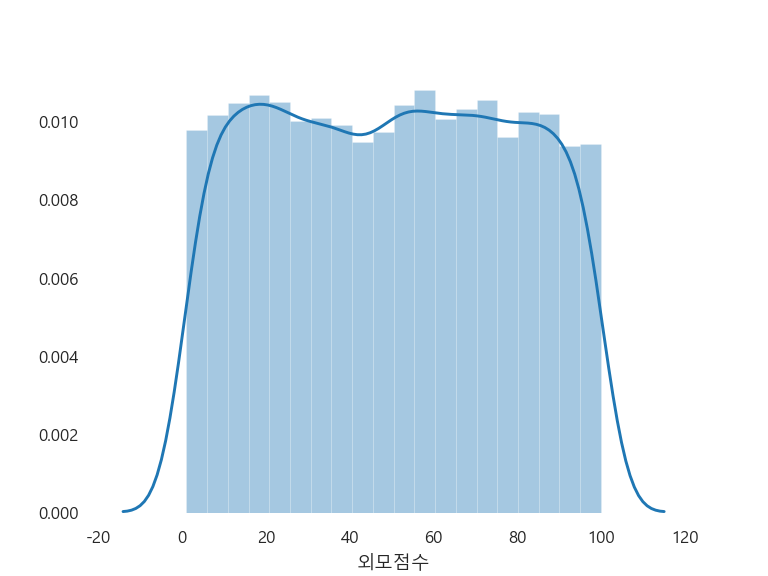

In [132]:
sns.distplot(train['외모점수'])

<IPython.core.display.Javascript object>


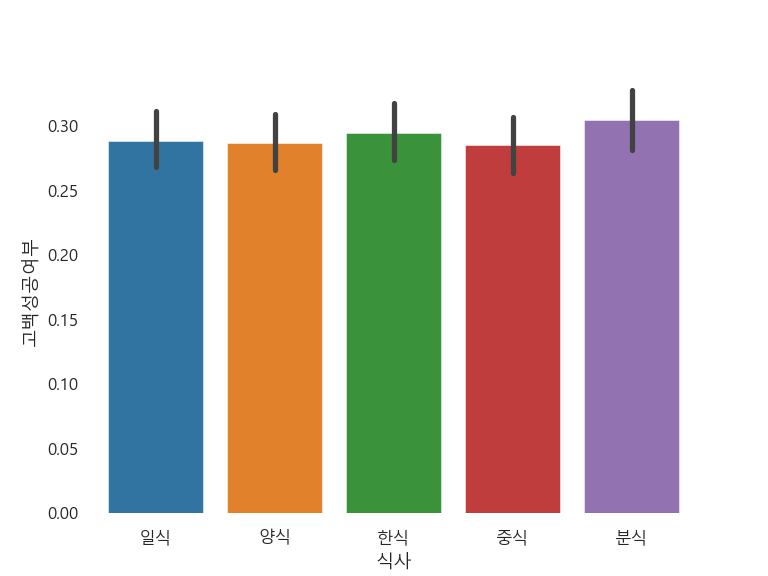

In [133]:
sns.barplot(x=train['식사'], y=train['고백성공여부'])

<IPython.core.display.Javascript object>


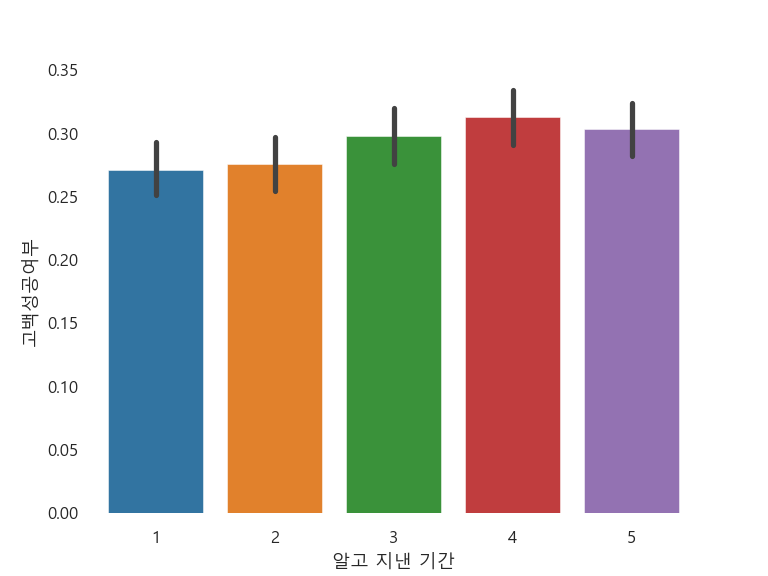

In [145]:
sns.barplot(x=train['알고 지낸 기간'], y=train['고백성공여부'])

<IPython.core.display.Javascript object>


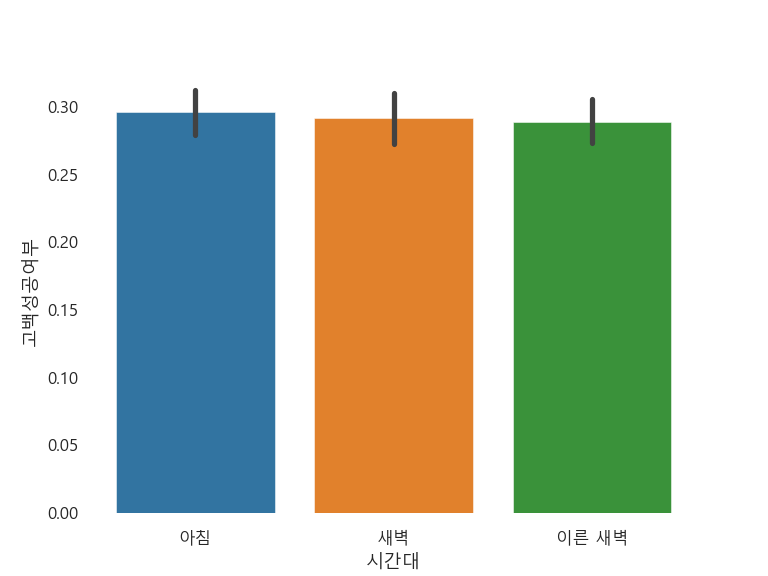

In [139]:
sns.barplot(x=train_all['시간대'], y=train_all['고백성공여부'])

<IPython.core.display.Javascript object>


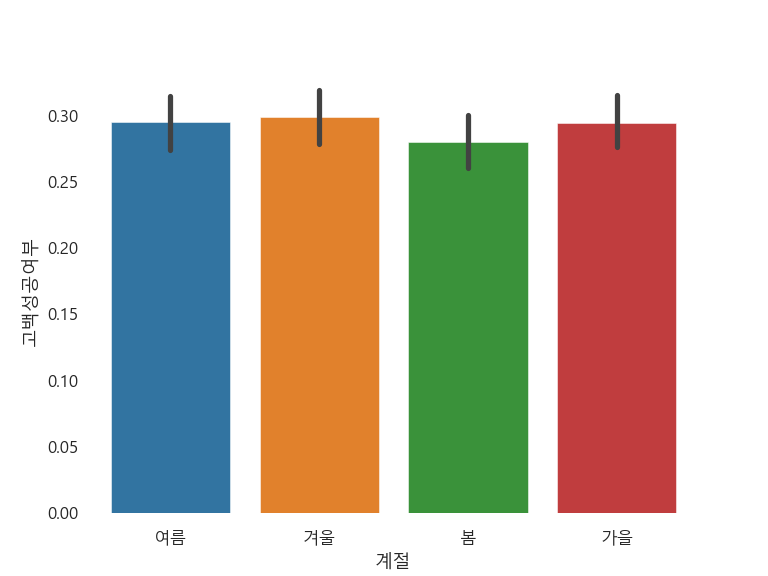

In [140]:
sns.barplot(x=train_all['계절'], y=train_all['고백성공여부'])

<IPython.core.display.Javascript object>


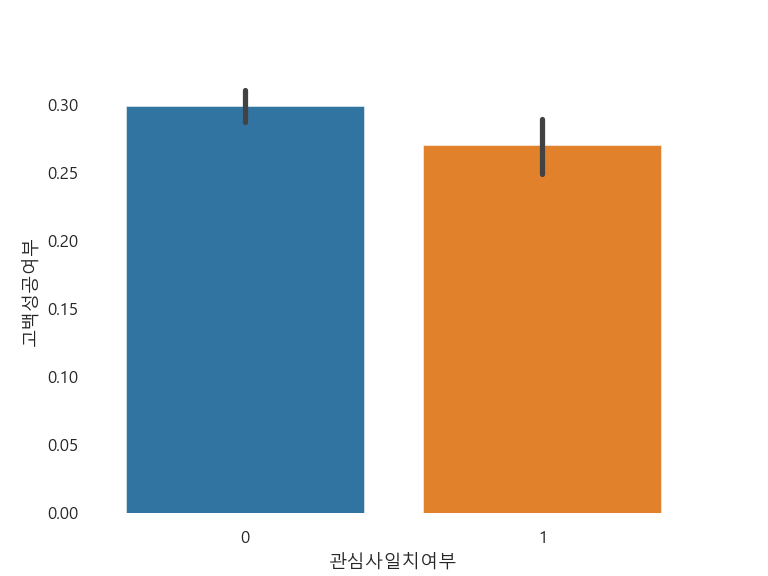

In [164]:
sns.barplot(x=train_all['관심사일치여부'], y=train_all['고백성공여부'])

In [84]:
train.describe()

,고백성공여부,나이(본인),나이(상대방),외모점수,알고 지낸 기간
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.291875,25.027125,24.993375,50.178750,2.984375
std,0.454654,3.146685,3.182821,28.705122,1.414083
min,0.000000,20.000000,20.000000,1.000000,1.000000
25%,0.000000,22.000000,22.000000,25.000000,2.000000
50%,0.000000,25.000000,25.000000,51.000000,3.000000
75%,1.000000,28.000000,28.000000,75.000000,4.000000
max,1.000000,30.000000,30.000000,100.000000,5.000000


- 나이는 본인 나이가 상대방 나이에 비해 아주 조금 높지만 큰 차이 없음
- 외모점수는 50점 기준으로 거의 uniform distribution인 듯
- 알고지낸 기간 역시 3년(?) 기준으로 1년부터 5년까지 uniform distribution
- 고백 성공여부는 실패가 확률에 비해 높은 상황(오버샘플링 필요?)
    - 시간은 연도 연도는 빼고 월(月), 주말 여부, 시간 기준으로 나눠봐야할 듯(모두 오전)
    - 관심사 일치 여부
    - 내 관심사, 상대방 관심사 dummy
    - 식사 더미
    - 나이 차이 절대값 하나, 나이 차이 절대값 아닌 거 하나
    - 이름은 필요없는 데이터일 듯
    - 알고 지낸 시간은 어느 기간 넘어가면 오히려 -일 듯

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 10 columns):
고백성공여부      8000 non-null int64
이름          8000 non-null object
시간          8000 non-null datetime64[ns]
나이(본인)      8000 non-null int64
나이(상대방)     8000 non-null int64
외모점수        8000 non-null int64
알고 지낸 기간    8000 non-null int64
관심사(본인)     8000 non-null object
관심사(상대방)    8000 non-null object
식사          8000 non-null object
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 625.1+ KB


In [146]:
def weekend(x):
    if (x==5) or (x==6):
        return 1
    else:
        return 0
    
def time_class(time):
    if time in range(0, 3):
        return '이른 새벽'
    elif time in range(3, 6):
        return '새벽'
    else:
        return '아침'
    
def season(month):
    if month in range(3, 6):
        return '봄'
    elif month in range(6, 9):
        return '여름'
    elif month in range(9, 12):
        return '가을'
    else:
        return '겨울'

def look(x):
    if x>45:
        return 1
    else:
        return 0

In [148]:
def feature_change(train):
    train['월'] = train['시간'].dt.month
    train['요일'] = train['시간'].dt.dayofweek
    train['시'] = train['시간'].dt.hour
    train['주말여부']= train['요일'].apply(weekend)
    
    train_drop = train.drop(['이름','시간'], axis=1)
    
    train_drop['나이차이_절대값'] = np.abs(train_drop['나이(본인)']-train_drop['나이(상대방)'])
    train_drop['나이차이'] = train_drop['나이(본인)']-train_drop['나이(상대방)']
    train_drop['나이차이_exp'] = np.exp(train_drop['나이차이'])
    train_drop['시간대'] = train_drop['시'].apply(time_class)
    train_drop['관심사일치여부'] = train_drop['관심사(본인)'] == train_drop['관심사(상대방)']
    train_drop['관심사일치여부'] = train_drop['관심사일치여부'].astype(int)
    train_drop['계절'] = train_drop['월'].apply(season)
    train_drop['알고 지낸 기간_exp'] = np.exp(train_drop['알고 지낸 기간'])
    train_drop['외모상'] = train_drop['외모점수'].apply(look)
    
    my_int = pd.get_dummies(train_drop['관심사(본인)'], prefix='내관심사')
    your_int = pd.get_dummies(train_drop['관심사(상대방)'], prefix='상대방관심사')
    rest = pd.get_dummies(train_drop['식사'])
    morning = pd.get_dummies(train_drop['시간대'])
    seasonal = pd.get_dummies(train_drop['계절'])
    
    train_all = pd.concat([train_drop, my_int, your_int, rest, morning, seasonal], axis=1)
    return train_all

In [149]:
train_all = feature_change(train)
test_all = feature_change(test)

In [150]:
using_columns = ['고백성공여부', '나이(본인)', '나이(상대방)', '외모점수', '알고 지낸 기간',
                 '알고 지낸 기간_2', '주말여부', '나이차이_절대값', '나이차이', '관심사일치여부',
                 '내관심사_게임', '내관심사_스포츠', '내관심사_영화', '내관심사_음악', '나이차이_exp',
                 '상대방관심사_게임', '상대방관심사_스포츠', '상대방관심사_영화', '상대방관심사_음악',
                 '분식', '양식', '일식','중식', '한식', '새벽', '아침', '이른 새벽', '가을', '겨울', 
                 '봄', '여름']
feature_columns = ['나이(본인)', '나이(상대방)', '외모점수', '알고 지낸 기간', '외모상',
                 '알고 지낸 기간_exp', '주말여부', '나이차이_절대값', '나이차이', '관심사일치여부',
                 '내관심사_게임', '내관심사_스포츠', '내관심사_영화', '내관심사_음악', '나이차이_exp',
                 '상대방관심사_게임', '상대방관심사_스포츠', '상대방관심사_영화', '상대방관심사_음악',
                 '분식', '양식', '일식','중식', '한식', '새벽', '아침', '이른 새벽', '가을', '겨울', 
                 '봄', '여름']
feature_columns2 = ['나이(본인)', '나이(상대방)', '외모점수', '알고 지낸 기간_exp', '외모상',
                    '주말여부', '나이차이_절대값', '관심사일치여부', '분식', '양식',
                    '일식','중식', '한식', '새벽', '아침', '이른 새벽', '가을', '겨울', 
                    '봄', '여름']

In [151]:
test_all = test_all[feature_columns2]

In [175]:
#report = train_all.profile_report()
#report.to_file('report.html')

## 모델에 들어가는 디자인 매트릭스 결정

In [152]:
X = train_all[feature_columns2]
y = train_all['고백성공여부']

In [153]:
for i in feature_columns2:
    X[i].astype(int)

In [154]:
sm = SMOTE(random_state=1)
X_resampled, y_resampled = sm.fit_sample(X,y)

In [155]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X_resampled, y_resampled,
                                                    test_size = 0.25, random_state = 1) 
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(8497, 20) (2833, 20) (8497,) (2833,)


In [165]:
pca = PCA(n_components=20)
pca.fit(X_resampled)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [166]:
pca.explained_variance_

array([2.87599659e+03, 8.35362590e+02, 1.03306751e+01, 9.26687348e+00,
       6.09158552e+00, 2.96119006e-01, 2.47977737e-01, 2.12832395e-01,
       1.96565610e-01, 1.88543234e-01, 1.82158726e-01, 1.60094227e-01,
       1.56658422e-01, 1.54177432e-01, 1.51221608e-01, 1.46850176e-01,
       7.49972666e-02, 6.26292030e-02, 2.01542027e-02, 1.28642217e-02])

In [167]:
train_PCs=pca.transform(train_x)[:,:-3]
test_PCs=pca.transform(test_x)[:,:-3]

## 모델 적합하기(손대지 않아도 됨)

In [168]:
RF = RandomForestClassifier(random_state=1)

param_grid={
    'n_estimators':[2000],
    'max_depth':[10]
}

In [169]:
cv = KFold(n_splits=5, shuffle=True ,random_state = 1)
gcv = GridSearchCV(RF, param_grid=param_grid, cv=cv, scoring='neg_log_loss')

In [170]:
gcv.fit(train_PCs, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score

In [171]:
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력
print('best score', gcv.best_score_)      # 최고의 점수

final params {'max_depth': 10, 'n_estimators': 2000}
best score -0.3992402664621657


## 결과확인(손대지 않아도 됨)

In [172]:
pred_y = gcv.predict_proba(test_PCs)
log_loss(test_y, pred_y)

0.39266200446899147

## 결과물 제출파일 만들기(손대지 않아도 됨)

In [64]:
test_predict = pd.DataFrame(gcv.predict_proba(test_PCs))

In [65]:
test_predict.head()

,0,1
0,0.558566,0.441434
1,0.665401,0.334599
2,0.976551,0.023449
3,0.644617,0.355383
4,0.621228,0.378772


결과물 확인

In [71]:
submission = pd.concat([test.loc[:,"이름"],test_predict.iloc[:,1]],axis=1)

## 제출파일 예시(손대지 않아도 됨)

In [77]:
submission=submission.iloc[:2000,:]
submission

,이름,1
0,임연재,0.441434
1,정지민,0.334599
2,남아재,0.023449
3,박수수,0.355383
4,하지동,0.378772
...,...,...
1995,임규의,0.458716
1996,노재영,0.999544
1997,신강해,0.416290
1998,권용용,0.374925


In [78]:
submission.to_csv("submission.csv", encoding='ansi', index=False)